In [1]:
"https://github.com/eonu/torch-fsdd"

'https://github.com/eonu/torch-fsdd'

In [ ]:
import torch
from torch import utils
from torch import nn
from torch.nn import functional as F
from data.torchfsdd.dataset import TorchFSDDGenerator
from data.augmentations.randphase import RandomAllPass

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt, numpy as np

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

pltr = lambda x: x.cpu().detach().numpy()

In [4]:
from optim.adam_ens_optim import AdamWEnsembleOptimizer
from optim.ens_optim import HybridEnsGradOptimizer
from optim.noise_sched import ExpAnnealingNS

In [5]:
# Initialize a generator for a local version of FSDD
fsdd = TorchFSDDGenerator(version='local', 
                        path='/home/theloni/audio-rc-rtl/exploration/data/torchfsdd/recordings',)
                        # transforms=RandomAllPass)

# Create two Torch datasets for a train-test split from the generator
train_set, val_set, test_set = fsdd.train_val_test_split(test_size=0.05, val_size=0.2)

In [6]:
len(train_set)

2279

In [7]:
BATCH = 64

In [8]:
SNR = 1e-6
# pads to 157*64 = 10048
def collate_fn(batch):
    """Collects together sequences into a single batch, arranged in descending length order."""
    batch_size = len(batch)

    # Sort the (sequence, label) pairs in descending order of duration
    batch.sort(key=(lambda x: len(x[0])), reverse=True)
    # Shape: list(tuple(tensor(TxD), int))

    # Create list of sequences, and tensors for lengths and labels
    sequences, lengths, labels = [], torch.zeros(batch_size, dtype=torch.long), torch.zeros(batch_size, dtype=torch.long)
    for i, (sequence, label) in enumerate(batch):
        lengths[i], labels[i] = len(sequence), label
        sequences.append(sequence)
        # print(sequence.shape)
    avg_rms = sum(seq.pow(2).mean().sqrt() for seq in sequences) / len(sequences)
    

    # Combine sequences into a padded matrix
    padded_sequences = torch.stack([torch.nn.functional.pad(seq,(0, 10048 - seq.shape[-1]), "constant", 0.0)+SNR*torch.randn(1, 10048)/avg_rms for seq in sequences])#torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    # Shape: (B x T_max x D)

    return padded_sequences, lengths, labels
    # Shapes: (B x T_max x D), (B,), (B,)

In [9]:
# Create training, validation and test set batch iterators

train_gen = utils.data.DataLoader(train_set, collate_fn=collate_fn, batch_size=BATCH, shuffle=True, pin_memory=True)
val_gen = utils.data.DataLoader(val_set, collate_fn=collate_fn, batch_size=len(val_set))
test_gen = utils.data.DataLoader(test_set, collate_fn=collate_fn, batch_size=len(test_set))

In [10]:
from models.rc import *
from models.pqmf import PQMF
from models.lfsr import LFSR

In [11]:
# lfsr = LFSR()
# fxps = torch.tensor([lfsr.gen_fxp_shift(3) for _ in range (10000)]).numpy()
# plt.hist(fxps, bins= 50)

In [12]:
157*64

10048

In [ ]:
uut = FSDDPipeline(32, 256, 4, 0.1, 4, 8).cuda()
sum(p.numel() for p in uut.parameters())

/net/flood/home/theloni/audio-rc-rtl/exploration/models/lfsr.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.poly_degrees = torch.tensor(polydegrees)


11124

In [14]:
# uut.rc.reshape_batchsize(1)
# uut.rc.update_feats(0.1*torch.randn(1, 32))
# uut.rc.features, (uut.rc.features.abs() > 0.95).sum()


In [15]:
# uut.rc.reset()
# torch.linalg.eigvals(uut.rc.feature_pushforward).abs()

In [ ]:
# import schedulefree
# adam = schedulefree.AdamWScheduleFree(uut.parameters())
# opt = AdamE...

# torch.autograd.set_grad_enabled(False)
# AdamWEnsembleOptimizer
opt = HybridEnsGradOptimizer(uut, 700, BATCH, 10, 
                             gpus=[f"cuda:{i}" for i in [0, 1, 3, 4, 5, 6, 7]], # kenneth is pinning gpu 2
                             ens_lr = 0.0025,
                             grad_lr = 0.005,
                             init_weight_std = 0.05,
                             noise_sched = ExpAnnealingNS(0.05, 0.005, 1-1e-9),
                             criterion = F.cross_entropy
)
opt.modelget_timeout = 30                             

In [17]:
# opt.debug_model().shape

In [18]:
# (uut.rc.feature_pushforward < 0).sum()

In [19]:
def clear_opt(opt):
    for xq, eflag, proc in zip(opt.x_qs, opt.exit_flags, opt.processes):
        eflag.set()
        xq.put(torch.zeros(1)) # dummy input push necessary for exit
        proc.join(timeout=1)
        eflag.clear()
    del opt
    import gc
    gc.collect()
    torch.cuda.empty_cache()

In [20]:
# clear_opt(opt)

In [ ]:
# L1reg = 1e-5
NEPOCH = 2500
for i in tqdm(range(1500, NEPOCH)):
    # uut.train()
    # adam.train()
    l, u, prec = None, None, None
    for j, (X, _, y) in enumerate(train_gen):
            X, y = X.cuda(), y.cuda()
            if X.shape[0] != BATCH:
                continue
            Y = F.one_hot(y, 10)
            
            # adam.zero_grad()
            # loss = F.cross_entropy(uut(X), y)
            # loss.backward()
            # adam.step()
            
            loss_closure = lambda: F.cross_entropy(opt.forward_model(X), y) #+ L1reg*dict(uut.named_modules())['2'].w_out.abs().sum()
            
            l, u, prec = opt.ens_step(X, Y.float(), loss_closure)
            # if (j+1) % 10 == 0:
            #     print(f"epoch {i} step {j} => loss {l.item():>0.4f} | mean uncert {u[1].item():>0.4f} | label precision {prec.item():>0.4f}")

    # uut.eval()
    # adam.eval()
    if (i + 1) % 10 == 0:
        test_X, _, test_y = next(iter(test_gen))
        test_X, test_y = test_X.cuda(), test_y.cuda()
        # opt.forward_model
        print(f"---------------------- epoch {i} ---------------------------")
        print(f"Test CrossEntropy {torch.nn.functional.cross_entropy(uut(test_X), test_y).item():>.4} | mean uncert {u[1].item():>0.4f} | label precision {prec.item():>0.4f}")
        if (i+1) % 50 == 0:

            val_X, _, val_y = next(iter(val_gen))
            val_X, val_y = val_X.cuda(), val_y.cuda()
            yhat = uut(val_X) 
            acc = (yhat.argmax(-1) == val_y).sum() / val_y.numel()
            print(f"Validation Accuracy {acc.item():>.4}")
        print("-------------------------------------------------")

  0%|          | 0/1000 [00:00<?, ?it/s]

---------------------- epoch 509 ---------------------------
Test CrossEntropy 2.066 | mean uncert 0.1541 | label precision 0.0250
-------------------------------------------------
---------------------- epoch 519 ---------------------------
Test CrossEntropy 2.066 | mean uncert 0.1559 | label precision 0.0250
-------------------------------------------------
---------------------- epoch 529 ---------------------------
Test CrossEntropy 2.062 | mean uncert 0.1574 | label precision 0.0250
-------------------------------------------------
---------------------- epoch 539 ---------------------------
Test CrossEntropy 2.06 | mean uncert 0.1589 | label precision 0.0250
-------------------------------------------------
---------------------- epoch 549 ---------------------------
Test CrossEntropy 2.061 | mean uncert 0.1607 | label precision 0.0250
Validation Accuracy 0.2917
-------------------------------------------------
---------------------- epoch 559 ---------------------------
Test Cro

In [48]:
19500/50

390.0

In [ ]:
named_ckpts = list(uut.named_parameters())
for name, ckpt in named_ckpts:
    torch.save(ckpt, f"ckpt/{name}_epoch{NEPOCH}.tensor")

In [51]:
uut(next(iter(train_gen))[0].cuda()).shape, next(iter(train_gen))[0].shape, next(iter(train_gen))[-1].shape

(torch.Size([64, 10]), torch.Size([64, 1, 10048]), torch.Size([64]))

In [52]:
val_X, _, val_y = next(iter(val_gen))
val_X, val_y = val_X.cuda(), val_y.cuda()
yhat = uut(val_X)
(yhat.argmax(-1) == val_y).sum() / val_y.numel()

tensor(0.3783, device='cuda:0')

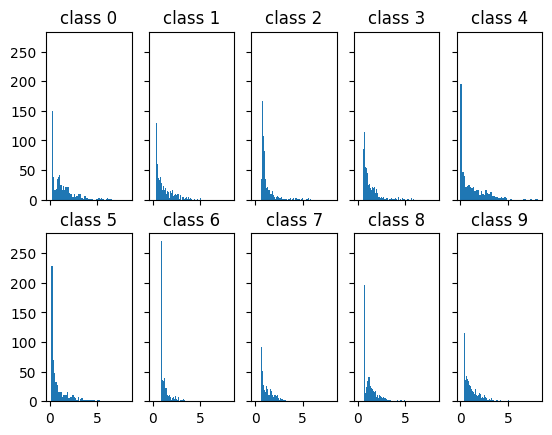

In [53]:
f, axs = plt.subplots(2, 5, sharex = True, sharey=True)
for i in range(2):
    for j in range(5):
        axs[i, j].hist(pltr(yhat[:,5*i + j]), bins = 50)
        axs[i, j].set_title(f"class {5*i+j}")
plt.show()

In [54]:
val_y.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')

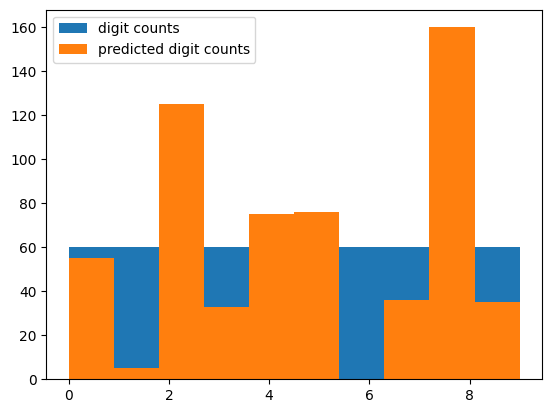

In [55]:
plt.hist(pltr(val_y), bins=10, label='digit counts')
plt.hist(predicted_labels, bins=10, label='predicted digit counts')
plt.legend()

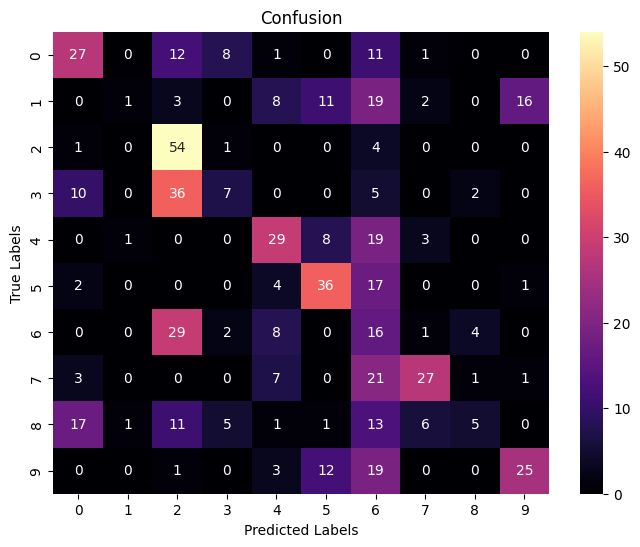

In [56]:

predicted_labels = np.argmax(pltr(yhat), axis=1)

# Compute confusion matrix
cm = confusion_matrix(pltr(val_y), predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=np.unique(pltr(val_y)), yticklabels=np.unique(pltr(val_y)))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion')
plt.show()

In [57]:
import matplotlib
from colour import Color
from matplotlib.colors import LinearSegmentedColormap, Color
# Calculate the total number of errors for each class
total_errors = cm.sum(axis=1) - np.diag(cm)

# Calculate percentage of the total error contributed by each class
cm_percentage_error = (cm.astype('float') / total_errors[:, np.newaxis]) * 100

# Plot confusion matrix with percentage error and magma color
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

xpos, ypos = np.meshgrid(np.arange(cm.shape[0]), np.arange(cm.shape[1]), indexing="ij")
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)
dx = dy = 0.5
dz = cm.flatten()

cvals  = cm_percentage_error.flatten()
colors = ["red","violet","blue"]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, cmap=cmap, norm=norm, zsort='average')

cbar = fig.colorbar(total_errors, ax=ax, extend='both')
cbar.minorticks_on()

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_zlabel('Number of Errors')
ax.set_title('Confusion Matrix (Percentage Error Contribution)')

plt.show()

ImportError: cannot import name 'Color' from 'matplotlib.colors' (/home/theloni/miniconda/envs/iir-torch/lib/python3.11/site-packages/matplotlib/colors.py)